<a href="https://colab.research.google.com/github/Trish-Pat/DIBootCamp/blob/main/Week8_Day5XP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [ ]:
# TODO : import the dataset

In [ ]:
df = pd.read_csv('/content/AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [ ]:
# TODO : take a quick look at the data
print("First rows of the dataset:")
print(df.head())

# Info
print("\nInfo:")

# Description
df.info()
print(f"\nDescription: {df.describe()}")

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Data size
print(f"\nData size: {df.shape}")

First rows of the dataset:
   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB

Description:             USER_ID       REVENUE
count  10000.000000  10000.000000
mean    4981.080200      0.099447
std     2890.590115      2.318529
min        2.000000      0.000000
25%     2468.750000      0.000000
50%     4962.000000      0.000000
75%     7511.500000      0.000000
max    10000.000000    196.010000

Missing values per column:
USER_ID         0
VARIANT_NAME    

Let's see if there are users who have two A/B test groups

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user
group_counts = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
group_distribution = group_counts.value_counts()
group_distribution

,count
VARIANT_NAME,
1,4783
2,1541


In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
df.groupby('USER_ID').VARIANT_NAME.nunique().value_counts(normalize=True)

,proportion
VARIANT_NAME,
1,0.756325
2,0.243675


---

What can you observe ? Should we exclude these users ? Why ?

---

We noticed that some users were assigned to more than one A/B test group — and they make up a significant portion, about 24% of all users. Including these users in the analysis would blur the effect of the changes, because they were exposed to multiple versions of the experiment. That’s why we exclude them: to keep the results clean and ensure that we measure the true impact of each variant on users who saw only one version.



In [ ]:
# TODO : users have 1 A/B test group ?

one_group = (group_counts == 1).sum()
print(f"\nNumber of users with only one group: {one_group}")

# TODO : Take only these users
user_with_one_group = group_counts[group_counts == 1].index


Number of users with only one group: 4783


In [ ]:
# TODO : Leave only records with users with the 1st ab test group
# df = df.drop_duplicates(subset=['USER_ID', 'VARIANT_NAME'], keep='first')
df = df[df['USER_ID'].isin(user_with_one_group)]

# TODO : Check that the number of users matches what it was before the exception
print(df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == group_distribution.iloc[0])

True


Let's see how the data is distributed

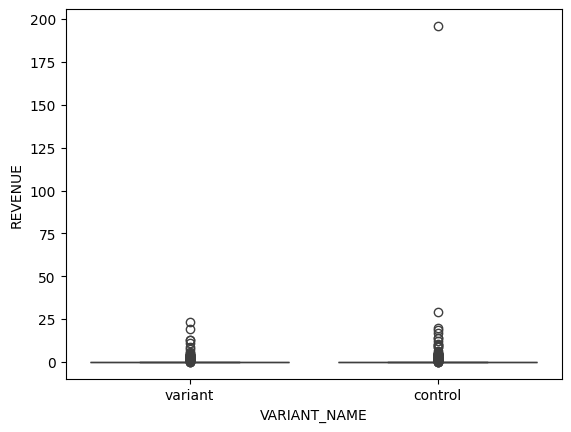

In [ ]:
# TODO : Check how the data is distributed using a box plot
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.show()


It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [ ]:
# TODO : Sort these revenue values in descending order
reveneu_sorted = df.sort_values(by='REVENUE', ascending=False)
reveneu_sorted.head()

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [ ]:
# TODO : See if user 3342 had other events with a strong outlier
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

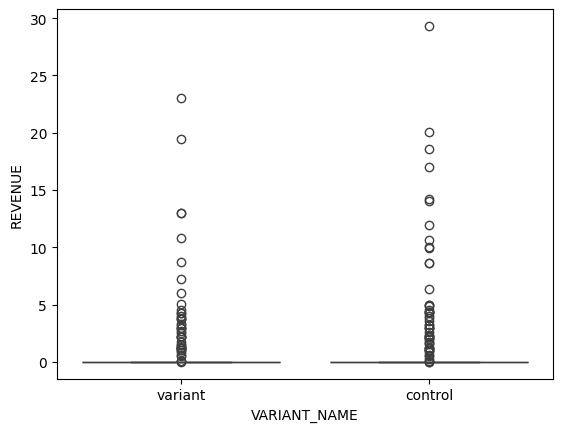

In [ ]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
df = df[df['USER_ID'] != 3342]
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.show()

---

What can you say about the users and their purchases ?

---
We can see a large concentration of users at 0. Most users did not purchase anything in either groups.

There are a few outliers. These are the minority of users who made purchases.

In [ ]:
# TODO : Check if there are users who have records with zero and positive revenue
user_revenue = df.groupby('USER_ID')['REVENUE'].apply(lambda x: (x > 0).any() and (x == 0).any())

mixed_users_count = user_revenue.sum()
print(f"Number of users with both zero and positive revenue: {mixed_users_count}")


Number of users with both zero and positive revenue: 37


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [ ]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0


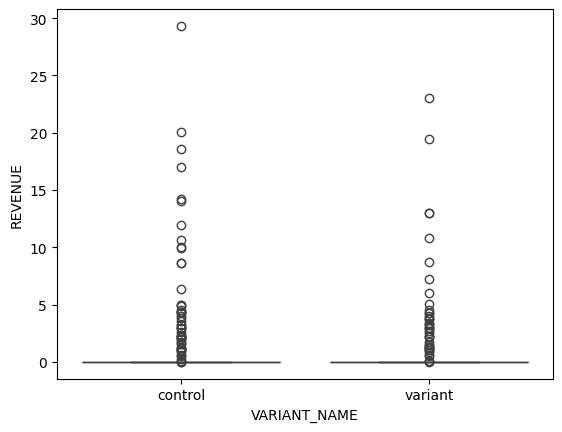

In [ ]:
# TODO : Visualize the resulting distribution of the data again.
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [ ]:
# TODO : get metrics by groups
all_stat = df.groupby('VARIANT_NAME').agg({
    'USER_ID': 'nunique',
    'REVENUE': ['mean', 'median', 'count', 'min', 'max', 'sum']
    })

# TODO : create two additional metrics to see relative changes
# Number of orders per user
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# Average revenue per user
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]


# TODO : add them to the rest of the metrics in a separate group
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID   REVENUE                                  per_user  \
             nunique      mean median count  min    max     sum   orders   
VARIANT_NAME                                                               
control         2389  0.114923    0.0  2389  0.0  29.32  274.55      1.0   
variant         2393  0.074935    0.0  2393  0.0  23.04  179.32      1.0   

                        
               revenue  
VARIANT_NAME            
control       0.114923  
variant       0.074935

---

What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

---

* The total revenue decreased (179.32)compared to the control group (274.55)

* The average check per user also decreased (0.074935 vs 0.114923)

* The number of orders per user remained exactly the same in both group (1.0).

---


Let's also see how paying users behave :

In [ ]:
# TODO : get metrics by groups
paid_stat = df[df['REVENUE'] > 0].groupby('VARIANT_NAME').agg({
    'USER_ID': 'nunique',
    'REVENUE': ['mean', 'median', 'count', 'min', 'max', 'sum']
    })

# TODO : create two additional metrics to see relative changes
# Number of orders per user
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]

# Average revenue per user
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]


# TODO : add them to the rest of the metrics in a separate group
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID   REVENUE                                   per_user  \
             nunique      mean median count   min    max     sum   orders   
VARIANT_NAME                                                                
control           53  5.180189   2.99    53  0.02  29.32  274.55      1.0   
variant           42  4.269524   2.97    42  0.02  23.04  179.32      1.0   

                        
               revenue  
VARIANT_NAME            
control       5.180189  
variant       4.269524

Let's look at the distributions of all and only paying users

/tmp/ipython-input-39-4101851425.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/tmp/ipython-input-39-4101851425.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'RE

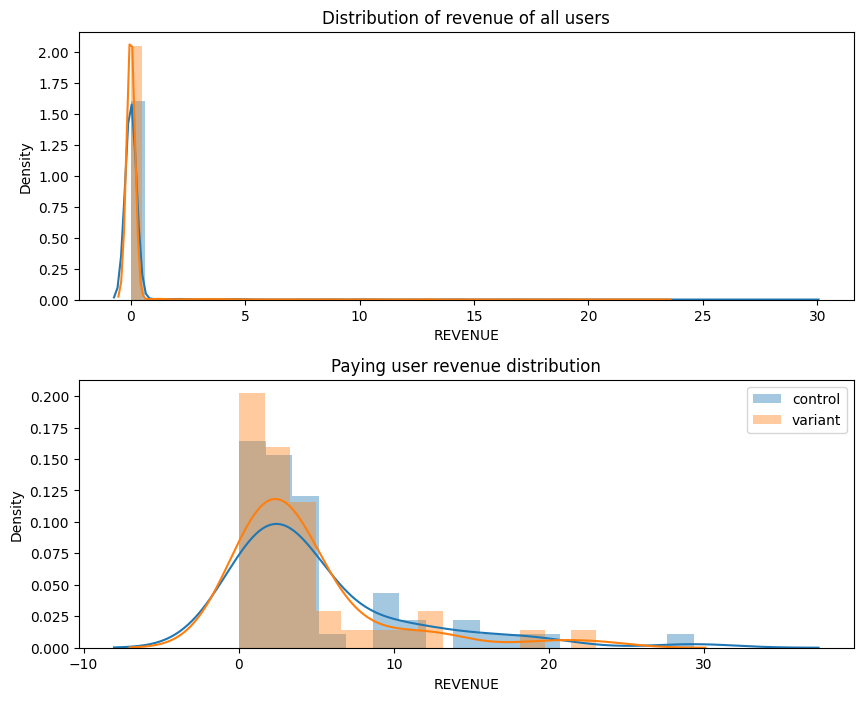

In [ ]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
stat, p_value = shapiro(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'])
print(f"Shapiro-Wilk test statistic: {stat}, p-value: {p_value:.2}")

Shapiro-Wilk test statistic: 0.06145986897942335, p-value: 1e-75


---

Is the null hypothesis about the normal distribution of the data rejected ?

---
The p-value < 0.05, we reject the null hypothesis. The data does not follow a normal distribution.



#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [ ]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,4687
False,95


In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
stat, p_value = mannwhitneyu(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'],
              df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'])
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p_value:.2}")

Mann-Whitney U test statistic: 2845109.0, p-value: 0.25


In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
stat, p_value = mannwhitneyu(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'],
              df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'])
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p_value:.2}")

Mann-Whitney U test statistic: 1029.0, p-value: 0.53


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users
variant = get_bootstrap_samples(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'].values, 1000)
control = get_bootstrap_samples(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'].values, 1000)


In [ ]:
# TODO : Generate samples for only paying users
variant_paid = get_bootstrap_samples(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'].values, 1000)
control_paid = get_bootstrap_samples(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'].values, 1000)

Let's look at the distribution of means in the ab test groups

Text(0.5, 1.0, 'Sample mean distribution for all users')

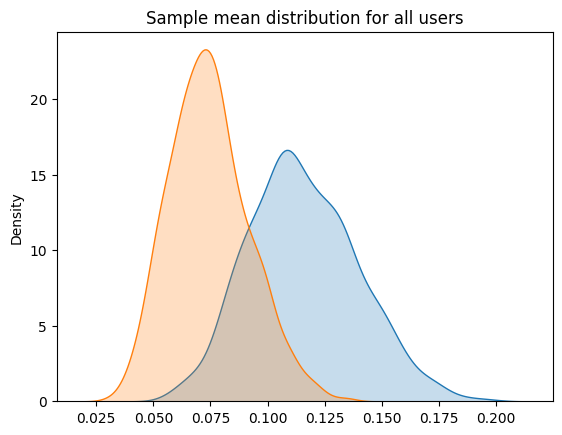

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), fill=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), fill=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

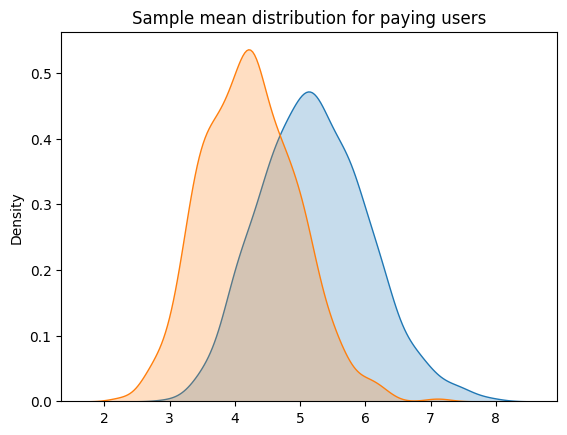

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), fill=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), fill=True, label='variant')
plt.title('Sample mean distribution for paying users')

---

Do you see any difference ? What about the confidence intervals ? Conclude.

---
* We observe that in both cases — all users and paying users only — the control group outperforms the test group in terms of average revenue. The distribution curves are clearly separated, indicating that the difference is likely statistically significant and not due to random variation. Therefore, the variant appears to perform worse than the control.

---


Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, fill=False).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

array([-0.10300812,  0.01836952])

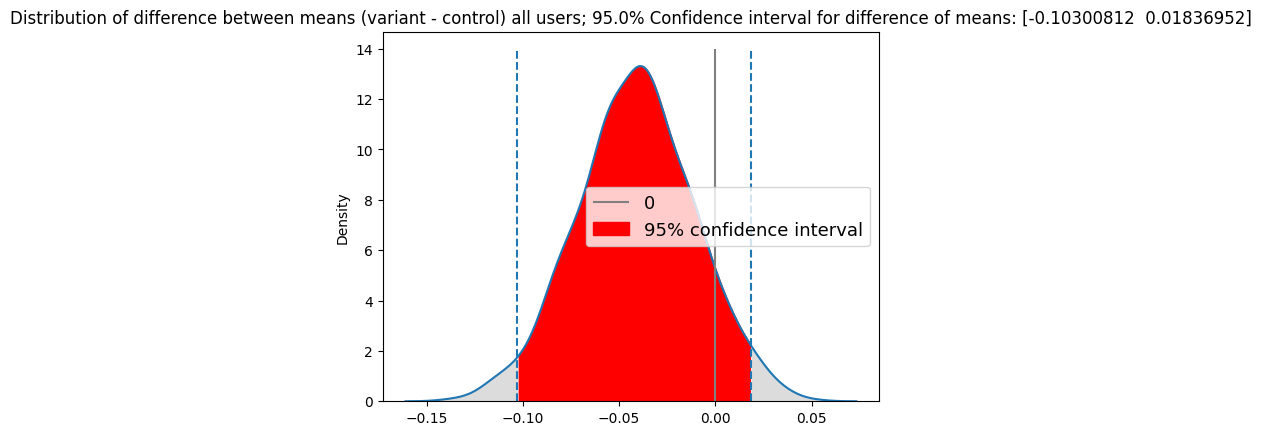

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

array([-3.02554021,  1.21193138])

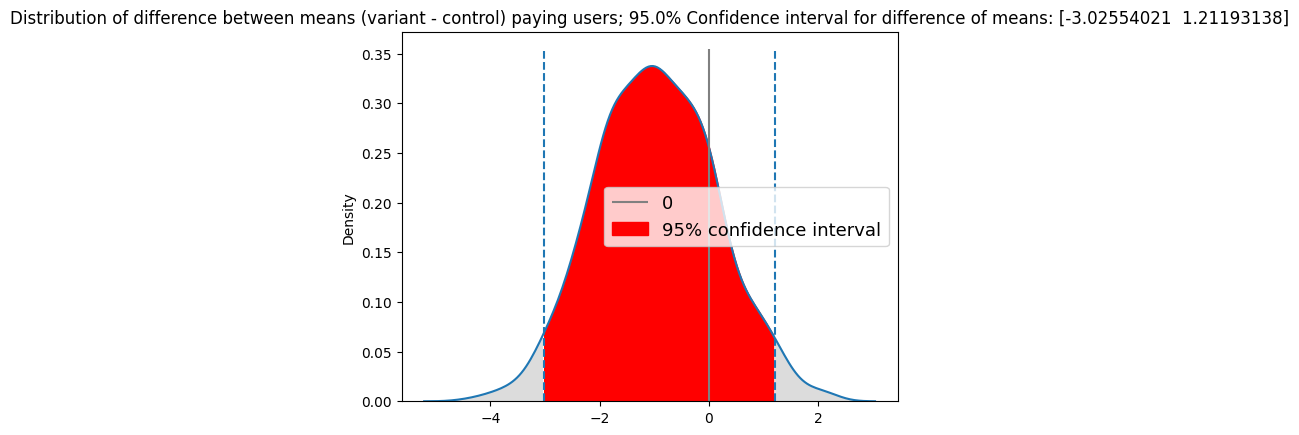

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.

---

* There is no statistically significant difference in average revenue between groups when we consider all users. The test does not allow us to confidently say that the variant performed better or worse than the control.

* Even when focusing only on paying users, we cannot confirm a statistically significant difference in revenue between variant and control. The difference could be positive or negative.

* n both cases; all users and paying users, the confidence intervals contain zero, which means the observed differences in average revenue could be due to chance. Therefore, there is no statistically significant effect of the variant compared to the control on average revenue.
